In [150]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Input, Dense, Activation
from keras import optimizers
from keras import regularizers
from keras.regularizers import Regularizer

In [203]:
#NOTE: none of these fxns are meant for single point input, input should always be a pd.DataFrame with more
#than one row, not an unreasonable request since sklearn makes you reshape 1D arrays.


# Data cleaning section: 

def split_and_scale(df, n, yes):
    """Splits training dataframe into predictors and properties to be predicted and returns them in 2 new dfs.
       This function assumes all of the predictors are grouped together on the right side of the df.
       df_train: training df
       n: number of properties to be predicted(number of outputs)"""
    properties, predictors = split(df, n)
    # COMMENT OUT THIS LINE IF YOU DONT WANT TO HAVE POLYNOMIAL TERMS IN YOUR TRAINING DATA
    # But note that accuracy is much better with this, but the model will have higher variance
    predictors_polynomial = polynomialize(predictors, yes)
    predictors_scaled_polynomial, predictors_scaler_polynomial = scaling(predictors_polynomial)
    return properties, predictors_scaled_polynomial, predictors_scaler_polynomial 


def polynomialize(series, yes):
    """Adds polynomial features to degree 3, including interaction features. 
    series: an input ndarray of floats to be polynomialized.
    This function returns a ndarray of all of the features specified above."""
    # Creating polynomial object
    if yes[0]:
        poly = PolynomialFeatures(degree = yes[1], interaction_only = yes[2])
        # Adding polynomial terms
        series = poly.fit_transform(series)
    return series

# Still in development, in case we want to add more terms that aren't polynomial
# def add_nonlinear_terms(df, n):
#     properties = df[df.columns[-n:]]
#     predictors = df[df.columns[:-n]]
#     i = np.arange(len(predictors.columns) * 4)
#     x = 0
#     for column in predictors.values:
#         predictors.assign(i[x]=column**2)
#         predictors.assign(column**3)
#         predictors.assign(np.exp(column))
#         predictors.assign(np.sign(column))
#     return properties, predictors


def split(df, n):
    """Takes an input pd.DataFrame and returns 2 ndarrays of the properties 
    and predictors."""
    properties = df[df.columns[-n:]].values
    predictors = df[df.columns[:-n]].values
    return properties, predictors


def scaling(df_train):
    """This function takes a pd.DataFrame, creates a sklearn.StandardScaler, scales the DataFrame,
       and returns the scaled data in a pd.DataFrame as well as the sklearn.StandardScaler object
       for transforming data back to unscaled form post machine learning.
       df_train: pd.DataFrame(for our purposes should be of shape 20 columns by an arbitrary number of rows)"""
    #Creating scaler object
    scaler = preprocessing.MinMaxScaler()
    #Scaling df_train
    scaled_data = pd.DataFrame(scaler.fit_transform(df_train))
    
    return scaled_data, scaler

# Training/predicting


def train_model(df_train, df_validation, model, n, yes):
    """This function takes a training DataFrame, validation DataFrame and a preconfigured model
       and trains said model on the training data followed by measuring error on validation data and 
       returning both the trained model and accuracy metric. This function assumes whatever parameter(s)
       being predicted is in the last column(s) of df_train.
       n: number of outputs
       because this function returns the trained model, more metrics can be performed later that are specific
       to whatever package it is in/the type of model it is
       Parameters"""
    #generating scaled data and their respective scaler objects
    t_properties, t_predictors_scaled, t_predictors_scaler = split_and_scale(df_train, n, yes)
    v_properties, v_predictors_scaled, v_predictors_scaler = split_and_scale(df_validation, n, yes)
    #supervised learning of predictors and properties to fit model, note: keras does not take pd.DataFrames for
    #training, using .values fixes this
    model.fit(t_predictors_scaled, t_properties)
    #predicting output of validation set
    predictions = pd.DataFrame(model.predict(v_predictors_scaled))
    #calculating RMSE from sklearn package
    val_error = np.sqrt(metrics.mean_squared_error(predictions, v_properties))
    return model, val_error, t_predictors_scaler


def model_prediction(test_data, fitted_model, scaler, n, yes):
    """Takes a fitted model and predicts the output of test data, returns the predicted data and accuracy.
       THIS FUNCTION IS ONLY TO BE USED FOR FUTURE PREDICTIONS OR TESTING(WHICH SHOULD ONLY BE DONE ONCE).
       Do not use this while training a model, that's what the validation data will be used for. We do not 
       want to introduce bias into our model by fitting to the test data
       n = number of predictors"""
    #splitting predictors and properties
    properties, predictors = split(test_data, n)
    predictors = polynomialize(predictors, yes)
    predictors_scaled = scaler.transform(predictors)
    #predicting based on scaled input predictors
    prediction = fitted_model.predict(predictors_scaled)
    #calculating MSE
    accuracy_metric = np.sqrt(metrics.mean_squared_error(properties, prediction))

    return prediction, accuracy_metric

# Below functions initialize all the different types of models we are looking at:


def neural_network():
    """Creates a neural network object to be passed into train_model function, can change properties of net
       here."""
    def model():
        model = Sequential()
        model.add(Dense(20, input_dim=20, kernel_initializer='normal', activation='relu'))
        model.add(Dense(30, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer = 'normal'))#kernel_initializer = initial values of outputs i think
        opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
        model.compile(loss='mean_squared_error', optimizer=opt)
        return model
    network = KerasRegressor(build_fn=model, epochs=36, batch_size=1000, verbose=1)
#     network.fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, 
    return network


def linear_regression():
    """creates a linear regression object"""
    regr = LinearRegression()
    return regr



In [126]:
# to go in cleaning section
# import clean

def test_split():
    data = {'column1': [2, 2, 3], 'column2': [1, 3, 5]}
    df = pd.DataFrame(data)
    one, two = clean.split(df, 1)
    assert one[0] == 1
    assert two[0] == 2
    return

def test_scaling():
    data = {'column1': [2.0, 2.0, 3.0], 'column2': [1.0, 3.0, 5.0]}
    df = pd.DataFrame(data)
    df, scaler = clean.scaling(df)
    assert df.loc[0].iloc[0] == 0
    assert df.loc[2].iloc[0] == 1
    return

# def test_linear_regression():
#     return

regr = LinearRegression()
type(regr)

sklearn.linear_model.base.LinearRegression

In [127]:
def train_test_split(df): 
    train, test_and_val = sklearn.model_selection.train_test_split(df, test_size=.30)
    test, val = sklearn.model_selection.train_test_split(test_and_val, test_size=.15)
    df_train = pd.DataFrame(train)
    df_val = pd.DataFrame(val)
    df_test = pd.DataFrame(test)
    df_train.drop(columns = 'Unnamed: 0',inplace = True)
    df_val.drop(columns = 'Unnamed: 0',inplace = True)
    df_test.drop(columns = 'Unnamed: 0',inplace = True) 
    df_train.drop(columns = 'efermi',inplace = True)
    df_val.drop(columns = 'efermi',inplace = True)
    df_test.drop(columns = 'efermi',inplace = True) 
    return df_train, df_val, df_test

In [128]:
data = pd.read_csv('MPD_Data_Processed.csv', sep = '\t')
data.head()

,Unnamed: 0,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,...,two_theta_2,two_theta_3,two_theta_4,two_theta_5,two_theta_6,two_theta_7,two_theta_8,two_theta_9,band_gap,efermi
0,mp-1000,100.0,76.808467,60.517635,29.361717,22.132998,21.657248,18.275875,17.467588,15.621411,...,35.823897,58.193688,44.255935,64.376264,127.447337,153.100605,134.637754,108.920846,1.5930,2.087033
1,mp-10009,100.0,78.502945,61.382764,59.581084,51.834414,42.578817,34.238297,32.474708,26.611831,...,19.268570,24.866325,43.790584,158.910531,161.241471,48.251965,31.649554,62.766975,0.7804,2.669606
2,mp-1001012,100.0,80.540257,76.206648,35.729962,34.640541,30.607739,26.076216,23.924735,18.361390,...,48.832011,23.855655,44.629498,33.990068,135.125592,91.443607,145.702725,41.952291,0.5765,3.071523
3,mp-1001015,100.0,77.813956,60.044813,44.937326,38.637906,25.032308,22.305078,21.849105,19.221977,...,169.262733,32.462334,42.581227,86.418577,64.924776,124.232687,22.798656,132.065583,0.6698,2.212315
4,mp-1001016,100.0,70.020649,63.037973,48.338026,34.510549,31.212189,27.679137,26.613327,24.481458,...,27.919942,168.168263,26.708785,86.053690,55.025631,165.708924,123.501849,77.054857,0.1396,2.638915


In [129]:
df_train, df_validation, df_test = train_test_split(data)
df_train.head()

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,amplitude_9,...,two_theta_1,two_theta_2,two_theta_3,two_theta_4,two_theta_5,two_theta_6,two_theta_7,two_theta_8,two_theta_9,band_gap
29493,100.0,59.019122,46.489814,36.386875,33.923631,30.607402,26.982228,20.816245,20.593990,16.722101,...,23.396588,18.994803,30.184238,26.108805,38.638263,37.320177,47.594375,31.777492,46.691300,1.6717
3472,100.0,35.932659,33.543125,30.740963,19.691183,17.921108,14.553240,14.422871,11.268463,9.165512,...,173.862243,38.830043,38.383269,55.744511,72.393174,171.461492,71.807265,150.177013,125.554660,0.0399
19349,100.0,50.566921,44.841388,22.249331,22.010489,19.830910,14.731571,13.734091,9.886251,8.373729,...,27.703849,175.420607,48.397586,38.682669,46.805085,36.831895,49.343805,69.608064,63.603707,4.6632
13628,100.0,96.453159,76.932091,75.390215,59.890057,52.848137,30.243548,18.814748,18.750769,17.951149,...,21.748494,178.550088,27.494580,42.795942,28.838183,46.672374,39.289610,52.331196,68.793257,5.6590
26401,100.0,57.430024,46.806990,44.183119,34.352380,31.056467,29.708588,26.503525,22.512494,21.520888,...,24.589751,20.219720,24.064786,32.280455,25.119731,30.584210,15.979342,33.146105,42.652168,0.8675


In [204]:
model, error, scaler = train_model(df_train, df_validation, neural_network(), 1, [False, 2, True])

Epoch 1/36
26810/26810 [==============================] - 1s 46us/step - loss: 5.8801
Epoch 2/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.4654
Epoch 3/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.3572
Epoch 4/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.3373
Epoch 5/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.3159
Epoch 6/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.2935
Epoch 7/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.2716
Epoch 8/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.2484
Epoch 9/36
26810/26810 [==============================] - 0s 4us/step - loss: 2.2263
Epoch 10/36
26810/26810 [==============================] - 0s 5us/step - loss: 2.2041
Epoch 11/36
26810/26810 [==============================] - 0s 6us/step - loss: 2.1861
Epoch 12/36
26810/26810 [==============================] - 0s 

In [205]:
error

1.4483989793545256

In [206]:
test_predictions, test_error = model_prediction(df_test, model, scaler, 1, [False, 2, True])

9766/9766 [==============================] - 0s 3us/step


In [207]:
test_predictions

array([2.1597717, 1.9235963, 2.0795944, ..., 2.1379144, 2.232712 ,
       2.275712 ], dtype=float32)

In [168]:
best_model = [model2, error2, scaler2]

In [185]:
linear, linerror, linscaler = train_model(df_train, df_validation, linear_regression(), 1, [True, 2, True])

In [211]:
lin_predictions, lin_error = model_prediction(df_test, linear, linscaler, 1, [True, 2, True])

In [229]:
def single_plot(x, y, figsize, title, xtitle, ytitle, xticks, yticks):

    fig, ax1 = plt.subplots(figsize = figsize)
    plt.title(title[0], size = title[1])
    plt.xticks(xticks[0], size = xticks[1])
    plt.yticks(yticks[0], size = yticks[1])
    plt.xlabel(xtitle[0], size = xtitle[1])
    plt.ylabel(ytitle[0], size = ytitle[1])
    ax1.set_xlim(0, 6)
    ax1.scatter(x, y, marker = '.', alpha = .7)
#     plt.savefig('nn_plot.png', bbox_inches='tight')
    return

single_plot(lin_predictions, df_test['band_gap'], (10,10),
            ('Linear Model Band Gap Test Error Plot', 18), ('Predicted Values(eV)', 12),
            ('Actual values(eV)', 12), (None, 12), (None, 12))



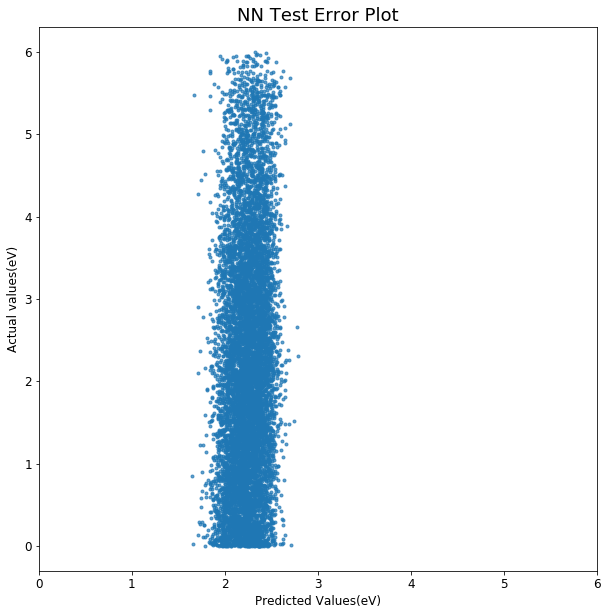

In [230]:
single_plot(test_predictions, df_test['band_gap'], (10,10),
            ('NN Test Error Plot', 18), ('Predicted Values(eV)', 12),
            ('Actual values(eV)', 12), (None, 12), (None, 12))

In [6]:
import numpy as np
import pandas as pd
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
mpdr = MPDataRetrieval(api_key='x5He3oeSg1eCaIU4')

In [18]:
# This statements obtains and stores the relevant data from MPD
# NOTE: Si was used as the criteria only for testing purposes. It will be changed later on
MPD_data = mpdr.get_dataframe(criteria='all',properties=['xrd', 'band_gap', 'efermi'])

def extract_data(MPD_data_row):
    """
    Extracts the relevant XRD data from the dictionary obtained from MPD
    
    Parameters:
    ----------
    MPD_data_row : Pandas dataframe
         A row of data for a single material from the full MPD dataframe 
    
    Returns:
    ----------
    clean_df: Pandas dataframe
        The top 10 XRD peaks and their corresponding two theta values for the material
    """
    
    # Extracting out the amplitude and two theta values from the dictionary contained inside the received data
    # then turning it into a pandas dataframe.
    dirty_df = pd.DataFrame(MPD_data_row['xrd']['Cu']['pattern'], columns=MPD_data_row['xrd']['Cu']['meta']) # Converts data into dataframe
    dirty_df.drop(['hkl','d_spacing'], axis=1, inplace=True) # Disposes of the hkl and d-spacing data

    # Sorting the peaks into the top 10 with the highest peaks
    dirty_df.sort_values('amplitude', ascending=False, inplace=True) # Sorts peaks from highest to smallest
    dirty_df.reset_index(drop=True, inplace=True) # Reseting index
    clean_df = dirty_df[:10] # Dropping all peaks below the top ten 

    return clean_df

# Function to reformat the data after cleaning
# Takes the dataframe and turns it into a dictionary wwhere all data points have a unique key
def reformat_data(MPD_data_row):
    """
    Reformats the cleaned data obtained from the extract_data function into a dictionary
    
    Parameters:
    ----------
    MPD_data_row : Pandas dataframe
         A row of data for a single material from the full MPD dataframe 
    
    Returns:
    ----------
    clean_df: Pandas dataframe
        The top 10 XRD peaks and their corresponding two theta values for the material
    """
    
    # Cleaning data and creating empty dictionary
    clean_df = extract_data(MPD_data_row)
    mat_dict = {}

    # Loop to assign each data point to a key and stores it within the dictionary
    for i in range(0,20):
        if i < 10:
            amp_key = ('amplitude_' + str(i))
            mat_dict[amp_key] = clean_df['amplitude'][i]

        else:
            theta_key = ('two_theta_' + str(i-10))
            mat_dict[theta_key] = clean_df['two_theta'][i-10]

    return mat_dict

# Function 
def produce_data(MPD_data):
    """
    Produces the XRD and DOS data for all the materials passed to the function 
    
    Parameters:
    ----------
    MPD_data : Pandas dataframe
      The dataframe filled with data obtained from MPD 
    
    Returns:
    ----------
    full_df: Pandas dataframe
        The peaks, two theta values, band gap, and fermi energy for all the materials passed to the function
    """
    
    # Creating prelimanry containers for XRD and DOS data
    xrd_data = {}
    dos_data = MPD_data.drop(['xrd'], axis=1)
    
    # Loop to run through each row of the dataframe
    for i in range(len(MPD_data)):
        
        # Conditional to skip over materials with less than 10 XRD peaks
        # or no fermi energies
        if len(MPD_data.iloc[i]['xrd']['Cu']['pattern']) >= 10 and np.isnan(MPD_data.iloc[i]['efermi']) == False:
            
            # Obtaining and storing the XRD data for a material into a dictionary
            ID = MPD_data.index[i]
            mat_dict = reformat_data(MPD_data.iloc[i])
            xrd_data[ID] = mat_dict
            
        else:
            
            # Replaces rows that failed the conditional with NaN
            # This is for easy removal od the rows
            dos_data.iloc[i] = float('nan')
    
    # Creating the final dataframe from the obtained XRD and DOS dataframes
    dos_df = dos_data.dropna()
    xrd_df = pd.DataFrame.from_dict(xrd_data, orient='index')
    full_df = pd.concat([xrd_df, dos_df], axis=1, sort=False)
    
    return full_df

produce_data(MPD_data)

CompositionError: all is an invalid formula!

In [11]:
# make sure inputs are correct, thats where shit gets fucked up
d_train = produce_data(MPD_data)
model, val_error, scaler = train_model(d_train.iloc[0:12], d_train.iloc[12:25],linear_regression(), 2)
predictions, accuracy = model_prediction(d_train.iloc[0:2], model, scaler, 2)

In [12]:
predictions

array([[1.0565    , 5.54577704],
       [1.82      , 3.21901393]])

In [13]:
accuracy

2.7240086067659812e-15